In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pgmpy
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from experiment_utils import credit_pipeline, fire_pipeline

import os

print(os.getcwd())

all_data = pd.read_csv('data/Credit10K.csv')

train_df, test_df, TARGET_COL = credit_pipeline(all_data)
print(f'Train shape: {train_df.shape}, Test shape: {test_df.shape}')
train_df.head()

/home/ignacy/cmu/bnc-formal-verification/src/paper_experiment_fire
Train shape: (8000, 12), Test shape: (2000, 12)


,PaymentHistory,WorkHistory,Reliability,Debit,Income,RatioDebInc,Assets,Worth,Profession,FutureIncome,Age,CreditWorthiness
9254,0,3,1,1,0,0,1,0,2,1,0,1
1561,3,2,0,1,1,0,1,2,1,1,0,0
1670,1,3,0,2,1,0,1,2,1,0,2,0
6087,3,2,1,0,1,1,1,1,1,0,0,0
6669,3,1,0,0,1,0,0,1,0,1,1,1


In [3]:
# Print all unique values in each column
for column in train_df.columns:
    print(f'{column}: {train_df[column].unique()}')

PaymentHistory: [0 3 1 2]
WorkHistory: [3 2 1 0]
Reliability: [1 0]
Debit: [1 2 0]
Income: [0 1 2]
RatioDebInc: [0 1]
Assets: [1 0 2]
Worth: [0 2 1]
Profession: [2 1 0]
FutureIncome: [1 0]
Age: [0 2 1]
CreditWorthiness: [1 0]


### Infer the structure of Bayesian Network

In [4]:
from pgmpy.estimators import HillClimbSearch, TreeSearch, PC, ExhaustiveSearch, MmhcEstimator
import warnings

# Filter user warnings
warnings.filterwarnings('ignore')

models = []

hc = HillClimbSearch(train_df)
hc_best_model = hc.estimate()
models.append(hc_best_model)

print(f'Hill climb done')

ts = TreeSearch(train_df, root_node=TARGET_COL)
ts_best_model = ts.estimate()
models.append(ts_best_model)

print(f'Tree search done')

pc = PC(train_df)
pc_best_model = pc.estimate(max_cond_vars=len(train_df.columns) - 2)
models.append(pc_best_model)

print(f'PC done')

# mmhc = MmhcEstimator(train_df)
# mmhc_best_model = mmhc.estimate(tabu_length=2)
# models.append(mmhc_best_model)

# print(f'MMHC done')

  0%|          | 0/1000000 [00:00<?, ?it/s]

Hill climb done


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Tree search done


  0%|          | 0/10 [00:00<?, ?it/s]

PC done


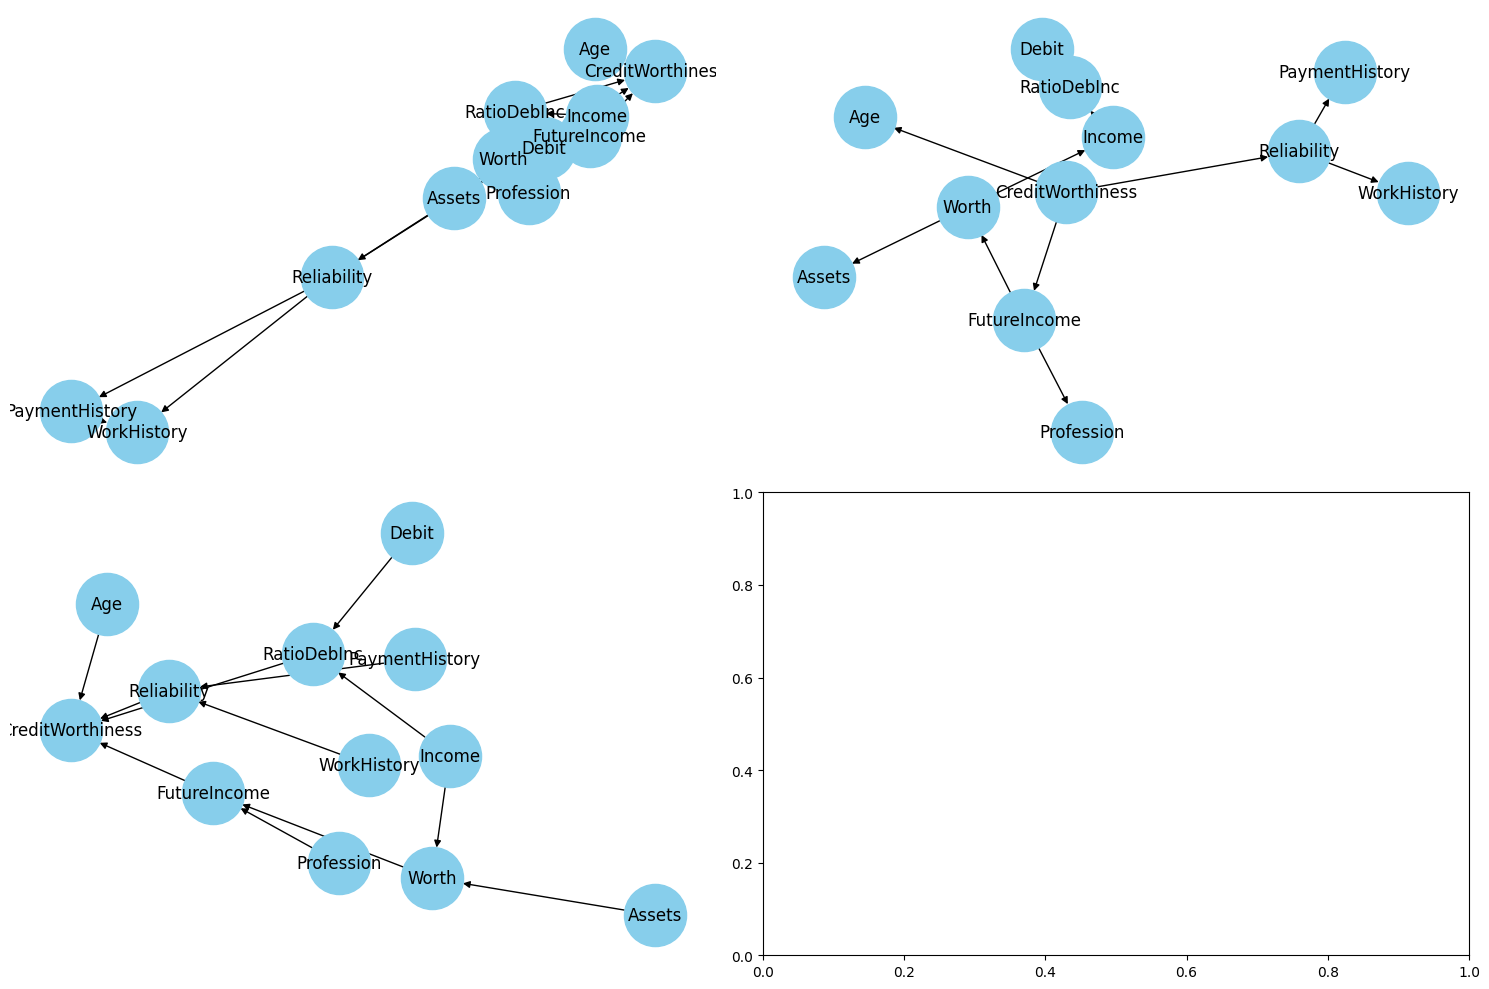

In [5]:
# Plot the model
import networkx as nx
import pylab as plt

fig, ax = plt.subplots(len(models) // 2 + 1, len(models) // 2 + 1, figsize=(15, 10))
ax = ax.ravel()
for i, model in enumerate(models):
        G = nx.DiGraph()
        G.add_edges_from(model.edges())
        pos = nx.spring_layout(G)
        nx.draw(G, 
                pos, 
                with_labels=True,
                node_size=2000,
                node_color="skyblue",
                ax=ax[i]
                )
plt.tight_layout()
plt.show()

In [6]:
best_model = models[1]

### Estimate the parameters of Bayesian Network

In [7]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

# Learing CPDs using Maximum Likelihood Estimators
model = BayesianNetwork(best_model.edges())

model.fit(train_df, estimator=MaximumLikelihoodEstimator)

# Print CPD of the target variable
print(model.get_cpds(TARGET_COL))

+---------------------+----------+
| CreditWorthiness(0) | 0.453125 |
+---------------------+----------+
| CreditWorthiness(1) | 0.546875 |
+---------------------+----------+


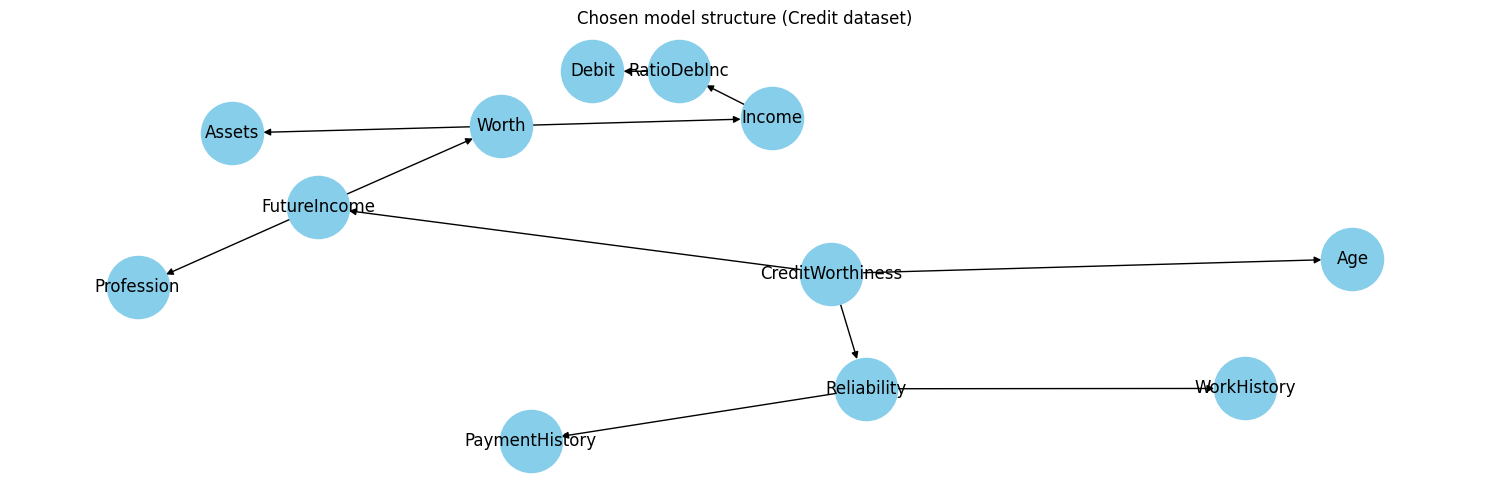

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
G = nx.DiGraph()
G.add_edges_from(model.edges())
pos = nx.spring_layout(G, seed=43)
nx.draw(G, 
        pos, 
        with_labels=True,
        node_size=2000,
        node_color="skyblue",
    )
plt.title(f'Chosen model structure (Credit dataset)')
plt.tight_layout()
plt.show()

### Check the accuracy of Bayesian Network on test data set

In [9]:
from sklearn.metrics import accuracy_score

# Predict the 'Status' variable on training data
y_pred = model.predict(train_df.drop(TARGET_COL, axis='columns'))

acc = accuracy_score(train_df[TARGET_COL], y_pred[TARGET_COL])
print('Accuracy (on training data): ', acc)

  0%|          | 0/6309 [00:00<?, ?it/s]

Accuracy (on training data):  0.7035


In [10]:
y_pred_proba = model.predict_probability(train_df.drop(TARGET_COL, axis='columns'))

y_pred_proba.head()

,CreditWorthiness_0,CreditWorthiness_1
9254,0.194651,0.805349
1561,0.427348,0.572652
1670,0.857140,0.142860
6087,0.572070,0.427930
6669,0.378656,0.621344


In [11]:
X_test = test_df.drop(TARGET_COL, axis='columns')


y_pred_carton_2 = model.predict(X_test)
y_pred_carton_2

  0%|          | 0/1882 [00:00<?, ?it/s]

,CreditWorthiness
0,1
1,0
2,0
3,0
4,1
...,...
1995,0
1996,1
1997,1
1998,1


In [12]:
test_acc = accuracy_score(test_df[TARGET_COL], y_pred_carton_2[TARGET_COL])

print(f'Accuracy on test data: {test_acc}')

Accuracy on test data: 0.7065


In [13]:
from pgmpy.readwrite import NETWriter
import json

NETWriter(model).write_net('models/credit10k.net')
NETWriter(model).write_net('../bnc_networks/credit10k.net')

DATASET_CONFIG = {
    "id": 1,
    "name": 'Credit10k',
    "filetype": "net",
    "vars": list(train_df.columns),
    "root": TARGET_COL,
    "leaves": 6,
    "threshold": 0.5,
    "input_filepath": "../bnc_networks/",
    "output_filepath": "../odd_models/"
}

with open('../bnc_configs/credit10k.json', 'w') as f:
    json.dump(DATASET_CONFIG, f, indent=4)

# Random baseline

In [14]:
a = [accuracy_score(test_df[TARGET_COL], np.random.permutation(test_df[TARGET_COL])) for _ in range(1000)]
a = np.array(a)
print(f'Accuracy on test data (random labels): {a.mean():.3f}')

Accuracy on test data (random labels): 0.502


## Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from math import floor

X_train = train_df.drop(TARGET_COL, axis='columns')
y_train = train_df[TARGET_COL]

X_test = test_df.drop(TARGET_COL, axis='columns')
y_test = test_df[TARGET_COL]

dt = DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=0, max_depth=3)
dt.fit(train_df.drop(TARGET_COL, axis='columns'), train_df[TARGET_COL])

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [16]:
train_accuracy = accuracy_score(y_train, dt.predict(X_train))
test_accuracy = accuracy_score(y_test, dt.predict(X_test))

print(f'Train accuracy: {train_accuracy:.5f}')
print(f'Test accuracy: {test_accuracy:.5f}')

Train accuracy: 0.72550
Test accuracy: 0.72850


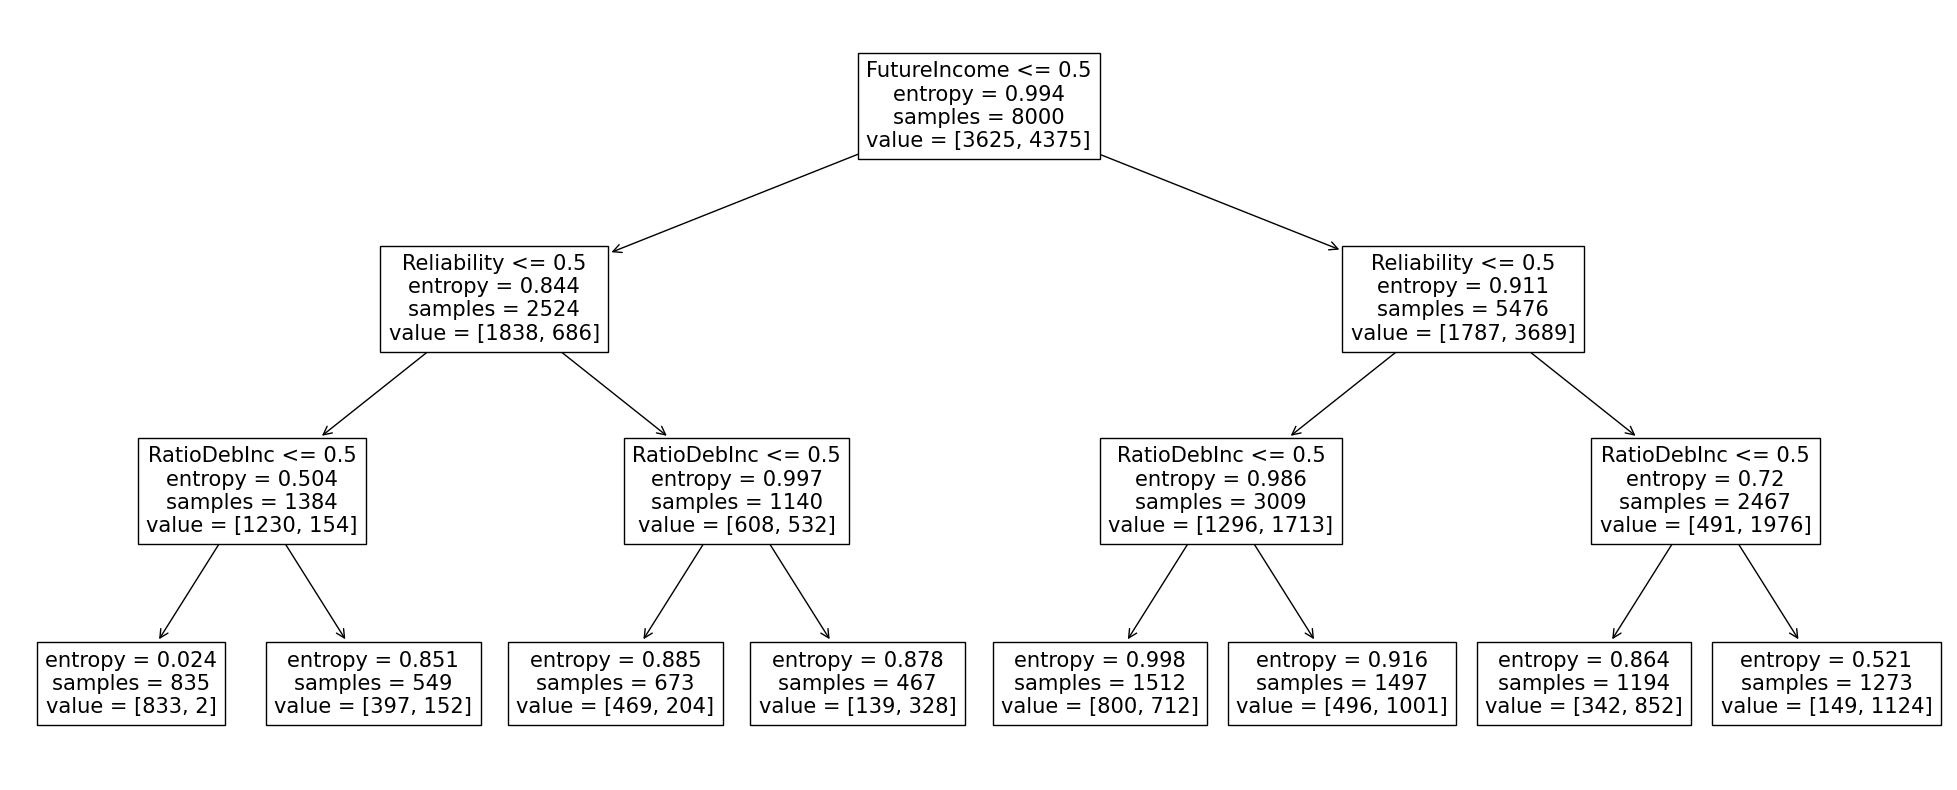

In [17]:
fig, ax = plt.subplots(figsize=(25, 10))
plot_tree(dt, feature_names=train_df.drop(TARGET_COL, axis='columns').columns.tolist(), ax=ax)
plt.show()

In [18]:
from extract_rules import extract_rules, add_coverage_to_rules, pretty_print, save_rules_to_json

X = X_train
y = y_train

# Get feature names (if available)
feature_names = X.columns.tolist()

# Get feature ranges (if available)
feature_ranges = {}
for feature in feature_names:
    feature_ranges[feature] = (X[feature].min(), X[feature].max())

# Extract rules for pure leaf nodes
rules = extract_rules(dt.tree_, 
                      feature_names, 
                    #   floor_threshold=False,
                    #   only_pure_leaves=False,
                      feature_ranges=feature_ranges)

rules = add_coverage_to_rules(rules, X)

for rule in rules:
    print(rule)

In [19]:
pretty_print(rules, X, y)

------------------------------------------------------------
Overall number of rules: 0


In [20]:
save_rules_to_json(rules, 'rules')

'rules.json'